In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#os.chdir("C:/Users/Nikita/Documents/GitHub/Self-learning-Monte-carlo-algorithms")
#os.chdir("C:/aut/Self-learning-Monte-carlo-algorithms")
import Ising
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from numba import jit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline
plt.style.use('ggplot')

In [2]:
!nvidia-smi

Sun Apr  5 20:05:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   37C    P0    44W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   33C    P0    42W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [19]:
class Net(torch.nn.Module):
    def __init__(self, input_size=10, hidden_size=64):
        super().__init__()
        self.conv = torch.nn.Conv2d(1, 1, kernel_size=[3, 3])
        self.act1 = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.05)
        self.fc1 = torch.nn.Linear((input_size-2)*(input_size-2), hidden_size)
        self.act2 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.shape[0], x.shape[2]**2)
        x = self.act1(self.fc1(x))
        x = self.act2(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [4]:
def find_point():
    global ind
    clouse = -1
    val1 = float("inf")
    output_val = net.forward(X_test.float())
    output_val_soft = cr(output_val).cpu().detach().numpy()
    
    y = []
    for i in range(X_test_time.shape[0]):
        mn = output_val_soft[:, 1][100*i:100*(i+1)].mean()
        y.append([X_test_time[i], mn])
    y.sort(key = lambda x: x[1])
    
    val = float("inf")
    for i in range(len(y)):
        mn = y[i][1]
        if abs(mn - 0.5) < abs(val - 0.5):
            clouse = i 
            val = mn
            
    ind.append(val)
    ind.append(y[clouse-1][0])
    ind.append(y[clouse+1][0] if clouse+1 != len(y) else y[clouse][0])
    ind.append(y[clouse][0])

# Loadind data and neural network training

In [5]:
def load(size, sample, n_obj):
    if sample == "train":
        X_path = "/home/nasorokin11/CPP/squre/size{}_min1_max3.5_step0.0625_batch1000_re100_N10000".format(str(size))
        y_path = "/home/nasorokin11/CPP/squre/labels_size{}_min1_max3.5_step0.0625_batch1000_re100_N10000".format(str(size))
    else:
        X_path = "/home/nasorokin11/CPP/size{}_min1_max3.5_step0.0625_batch1000_re100_N10000_triangular".format(str(size))
        y_path = "/home/nasorokin11/CPP/labels_size{}_min1_max3.5_step0.0625_batch1000_re100_N10000_triangular".format(str(size))
        
    with open(X_path) as fl:
            lines = fl.readlines()
    X_test = np.zeros((n_obj, size, size), dtype = np.int8)
    curr = 0
    for i in tqdm(range(len(lines))):
        if lines[i] == ';\n':
            curr += 1
        else:
            X_test[curr] = np.array(list(map(lambda x: int(x), lines[i][:-2].split(" "))))
        
    del lines
        
    with open(y_path) as fl:
        lines = fl.readlines()
    y_test = []
    for i in range(len(lines)):
        y_test.append(int(lines[i][0]))
    return X_test, y_test

In [6]:
def plot_fitting():
    net.eval()
    output_val = net.forward(X_test.to(device).float())
    output_val_soft = cr(output_val).cpu().detach().numpy()
    x_line = np.arange(0,1.2,0.2)
    output_0 = []
    for i in range(X_test_time.shape[0]):
        output_0.append(output_val_soft[:, 0][100*i:100*(i+1)].mean())
    plt.plot(X_test_time, output_0, '-.^g', alpha=0.5)
    output_1 = []
    for i in range(X_test_time.shape[0]):
        output_1.append(output_val_soft[:, 1][100*i:100*(i+1)].mean())
    plt.plot(X_test_time, output_1, '-.^b', alpha=0.5)
    plt.plot([3.65]*x_line.shape[0], x_line, '-')
    plt.show()

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
# load
size = 256
x = np.arange(1, 3.5, 0.0625)
X_train, y_train = load(size, "train", 40000)
X_test, y_test = load(size, "test", 30100)
            
print("size:", size)
    
X_test_time = np.arange(1, 4, 0.01)
    
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], size*size)
X_test = torch.from_numpy(X_test).to(device)
y_test = np.array(y_test)
    
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], size*size)
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(np.array(y_train))
train_data = TensorDataset(X_train, y_train)
# dataloaders
train_data = TensorDataset(X_train, y_train)
batch_size = 16384

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

torch.cuda.empty_cache()
#train


KeyboardInterrupt: 

In [ ]:
net = Net(size*size)
net.to(device)
net.train()
    
cr = torch.nn.Softmax()
criterion = torch.nn.CrossEntropyLoss()
lr=3*(10**-4)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
for e in tqdm(range(400)):
    net.train()    
    for X, y in train_loader:
        output = net.forward(X.to(device).float())
        y = y.to(device)
            
        loss = criterion(output, y.long())
        loss.backward()
        optimizer.step()
        net.zero_grad()

    if e % 10 == 0:
        net.eval()
        output = []
        output_val = []
        labels_train = []
        output_val = net.forward(X_test.float())
        for X, y in train_loader:
            output += net.forward(X.to(device).float()).tolist()
            labels_train += y.tolist()
            
        output_val = net.forward(X_test.float())

        print(e, ":", "val accuracy:", 
                    accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test),
                    "train accuracy:", accuracy_score(np.around(cr(torch.Tensor(output))[:, 1].detach().numpy()),labels_train))
    
net.eval()
plot_fitting()
find_point()
    
output_val = net.forward(X_test.to(device).float())
acc.append(accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test))
print("T", ind[-1])

In [16]:
net

Net(
  (conv): Conv2d(1, 1, kernel_size=[3, 3], stride=(1, 1))
  (act1): ReLU()
  (fc1): Linear(in_features=900, out_features=64, bias=True)
  (act2): ReLU()
  (drop): Dropout(p=0.05, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


size: 16


0 : val accuracy: 0.11737541528239202 train accuracy: 0.470375


/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10 : val accuracy: 0.3404983388704319 train accuracy: 0.60035
20 : val accuracy: 0.4021262458471761 train accuracy: 0.620175
30 : val accuracy: 0.6543189368770764 train accuracy: 0.756075
40 : val accuracy: 0.7400332225913622 train accuracy: 0.78195
50 : val accuracy: 0.792890365448505 train accuracy: 0.78545
60 : val accuracy: 0.8188039867109634 train accuracy: 0.781075
70 : val accuracy: 0.8308637873754153 train accuracy: 0.7784
80 : val accuracy: 0.8307308970099668 train accuracy: 0.783675
90 : val accuracy: 0.8224584717607973 train accuracy: 0.79265
100 : val accuracy: 0.8152159468438538 train accuracy: 0.7997
110 : val accuracy: 0.806843853820598 train accuracy: 0.804275
120 : val accuracy: 0.8019601328903655 train accuracy: 0.806475
130 : val accuracy: 0.7982392026578073 train accuracy: 0.808175



/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


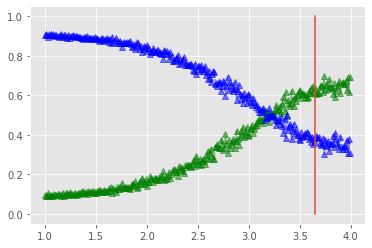

T 3.230000000000002


/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/opt/software/python/anaconda/2019_10/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



size: 32


0 : val accuracy: 0.6206644518272425 train accuracy: 0.63265
10 : val accuracy: 0.8304318936877076 train accuracy: 0.8242
20 : val accuracy: 0.8714950166112957 train accuracy: 0.83165
30 : val accuracy: 0.8808970099667774 train accuracy: 0.835475
40 : val accuracy: 0.8778073089700996 train accuracy: 0.85245
50 : val accuracy: 0.8688704318936877 train accuracy: 0.867975
60 : val accuracy: 0.8630564784053156 train accuracy: 0.8731
70 : val accuracy: 0.8606312292358804 train accuracy: 0.875175
80 : val accuracy: 0.859468438538206 train accuracy: 0.876575
90 : val accuracy: 0.8580066445182725 train accuracy: 0.87775


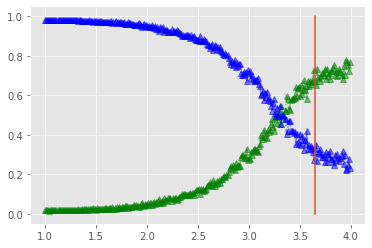

T 3.340000000000002



size: 64


0 : val accuracy: 0.7446511627906977 train accuracy: 0.6332
10 : val accuracy: 0.8246511627906977 train accuracy: 0.70505
20 : val accuracy: 0.7490033222591362 train accuracy: 0.75295
30 : val accuracy: 0.7281063122923588 train accuracy: 0.76505
40 : val accuracy: 0.7077740863787375 train accuracy: 0.78195
50 : val accuracy: 0.7086046511627907 train accuracy: 0.7967
60 : val accuracy: 0.7266112956810631 train accuracy: 0.813375
70 : val accuracy: 0.7544186046511628 train accuracy: 0.834525


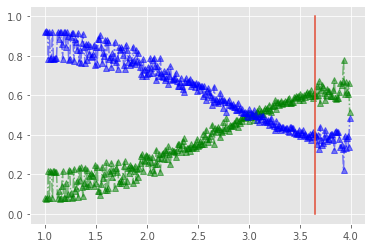

T 3.040000000000002


In [ ]:
ind = []
left = []
right = []
acc = []
size = 16
while size <= 128:
    # load
    x = np.arange(1, 3.5, 0.0625)
    X_train, y_train = load(size, "train", 40000)
    X_test, y_test = load(size, "test", 30100)
            
    print("size:", size)
    
    X_test_time = np.arange(1, 4, 0.01)
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], 1, size, size)
    X_test = torch.from_numpy(X_test).to(device)
    y_test = np.array(y_test)
    
    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], 1, size, size)
    X_train = torch.from_numpy(X_train).to(device)
    y_train = torch.from_numpy(np.array(y_train)).to(device)
    train_data = TensorDataset(X_train, y_train)
    
    torch.cuda.empty_cache()
    #train
    net = Net(size)
    net.to(device)
    net.train()
    
    cr = torch.nn.Softmax()
    criterion = torch.nn.CrossEntropyLoss()
    lr=3*(10**-4)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
    early_stoping = 5
    last_er = -1
    for e in tqdm(range(400)):
        net.train()    
        output = net.forward(X_train.float())
        loss = criterion(output, y_train.long())
        loss.backward()
        optimizer.step()
        net.zero_grad()

        if e % 10 == 0:
            net.eval()
            output = []
            output_val = []
            labels_train = []
            output = net.forward(X_train.float())
            output_val = net.forward(X_test.float())
            er = accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test)
            
            if last_er >= er:
                early_stoping -= 1
            else:
                early_stoping = 5
            last_er = er

            print(e, ":", "val accuracy:", 
                    accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test),
                    "train accuracy:", accuracy_score(np.around(cr(output)[:, 1].cpu().detach().numpy()), y_train.cpu().detach().numpy()))
        
        if early_stoping < 0:
            break
    net.eval()
    plot_fitting()
    find_point()
    
    output_val = net.forward(X_test.to(device).float())
    acc.append(accuracy_score(np.around(cr((output_val))[:, 1].cpu().detach().numpy()), y_test))
    print("T", ind[-1])
    size *=2


In [11]:
early_stoping

10